In [1]:
import json
import numpy as np
import pandas as pd
import unidecode
import string
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Softmax
from keras.metrics import mean_squared_error

In [2]:
def refine_texts(text):
    text = unidecode.unidecode(text) # Removes Accent from the name
    text = text.lower() # Convert's everything to lowercase
    #text = text.replace(',','')
    for s in text:
        if s not in string.ascii_lowercase:
            text = text.replace(s,' ')
        else:
            continue
    return text.replace(' ','')

In [3]:
f = open('data/test.json')
data_test = json.load(f)
f.close()
f = open('data/train.json')
data_train = json.load(f)
f.close()

In [4]:
# Creating the target dataset y
y = [i['cuisine'] for i in data_train]
y = pd.DataFrame(y,columns=['Cuisine'])

# Printing how many datapoints we have corresponding to each cuisine
count = 1
for j in set(y.Cuisine):
    print('%i Cuisine: %s'%(count,j))
    count+= 1
    print('Occurrence: %i'%list(y.Cuisine).count(j))
    print('\n')

1 Cuisine: jamaican
Occurrence: 526


2 Cuisine: russian
Occurrence: 489


3 Cuisine: vietnamese
Occurrence: 825


4 Cuisine: greek
Occurrence: 1175


5 Cuisine: southern_us
Occurrence: 4320


6 Cuisine: british
Occurrence: 804


7 Cuisine: japanese
Occurrence: 1423


8 Cuisine: italian
Occurrence: 7838


9 Cuisine: filipino
Occurrence: 755


10 Cuisine: brazilian
Occurrence: 467


11 Cuisine: irish
Occurrence: 667


12 Cuisine: chinese
Occurrence: 2673


13 Cuisine: indian
Occurrence: 3003


14 Cuisine: thai
Occurrence: 1539


15 Cuisine: moroccan
Occurrence: 821


16 Cuisine: korean
Occurrence: 830


17 Cuisine: mexican
Occurrence: 6438


18 Cuisine: spanish
Occurrence: 989


19 Cuisine: french
Occurrence: 2646


20 Cuisine: cajun_creole
Occurrence: 1546




In [5]:
# Creating y_dummies as 1-hot vector dataframe
y_dummies = pd.get_dummies(y)
y_dummies.head()

,Cuisine_brazilian,Cuisine_british,Cuisine_cajun_creole,Cuisine_chinese,Cuisine_filipino,Cuisine_french,Cuisine_greek,Cuisine_indian,Cuisine_irish,Cuisine_italian,Cuisine_jamaican,Cuisine_japanese,Cuisine_korean,Cuisine_mexican,Cuisine_moroccan,Cuisine_russian,Cuisine_southern_us,Cuisine_spanish,Cuisine_thai,Cuisine_vietnamese
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
# Creating the word embedding model here. 
# Please note 'embedding_dimension' is a hyperparameter here.
# Please change it and experiment with it.
sentences = [i['ingredients'] for i in data_train]
embedding_dimension = 200
w2v = Word2Vec(sentences, min_count=3, vector_size = embedding_dimension)
word_vectors = w2v.wv

In [128]:
# Creating the training dataframe 'X'
Data = np.zeros((len(data_train),embedding_dimension))
for i in range(len(data_train)):
    for j in data_train[i]['ingredients']:
        try:
            Data[i]+= word_vectors[j]
        except:
            Data[i]+= 0            
X = pd.DataFrame(Data)

0.13312270419628475

In [129]:
Training_index = []
for cuisine in set(y.Cuisine.values):
    Training_index+= list(y.loc[y.Cuisine==cuisine].index[:1000])
len(Training_index)

17173

In [133]:
Model = Sequential(
    [
        #Dense(50, input_dim=embedding_dimension, activation = 'relu', name='layer1',),
        Dense(20, activation= 'relu'),
        Softmax(1),
    ]
)
Model.compile(loss=mean_squared_error, optimizer= 'Adam', metrics= 'accuracy')


(17173, 20)

In [135]:
X_norm = (X-X.mean())/X.std() # Normalizing the training data before feeding it into the model
history = Model.fit(X_norm,
                    y_dummies, 
                    validation_split=.2, 
                    epochs=150, 
                    batch_size = 4)

Epoch 1/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0273 - accuracy: 0.5891 - val_loss: 0.0260 - val_accuracy: 0.6094
Epoch 2/150
7955/7955 [==============================] - 9s 1ms/step - loss: 0.0258 - accuracy: 0.6157 - val_loss: 0.0248 - val_accuracy: 0.6331
Epoch 3/150
7955/7955 [==============================] - 9s 1ms/step - loss: 0.0253 - accuracy: 0.6262 - val_loss: 0.0246 - val_accuracy: 0.6339
Epoch 4/150
7955/7955 [==============================] - 9s 1ms/step - loss: 0.0251 - accuracy: 0.6294 - val_loss: 0.0252 - val_accuracy: 0.6245
Epoch 5/150
7955/7955 [==============================] - 9s 1ms/step - loss: 0.0250 - accuracy: 0.6320 - val_loss: 0.0254 - val_accuracy: 0.6255
Epoch 6/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0248 - accuracy: 0.6341 - val_loss: 0.0250 - val_accuracy: 0.6328
Epoch 7/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0247 - accuracy: 0.6376 - val_loss: 0.0249 - val

7955/7955 [==============================] - 11s 1ms/step - loss: 0.0234 - accuracy: 0.6598 - val_loss: 0.0239 - val_accuracy: 0.6486
Epoch 57/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0234 - accuracy: 0.6577 - val_loss: 0.0239 - val_accuracy: 0.6559
Epoch 58/150
7955/7955 [==============================] - 11s 1ms/step - loss: 0.0234 - accuracy: 0.6618 - val_loss: 0.0245 - val_accuracy: 0.6471
Epoch 59/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0234 - accuracy: 0.6600 - val_loss: 0.0239 - val_accuracy: 0.6556
Epoch 60/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0234 - accuracy: 0.6589 - val_loss: 0.0237 - val_accuracy: 0.6593
Epoch 61/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0233 - accuracy: 0.6630 - val_loss: 0.0238 - val_accuracy: 0.6548
Epoch 62/150
7955/7955 [==============================] - 10s 1ms/step - loss: 0.0233 - accuracy: 0.6617 - val_loss: 0.0240 - val_a

7955/7955 [==============================] - 20s 3ms/step - loss: 0.0230 - accuracy: 0.6675 - val_loss: 0.0237 - val_accuracy: 0.6629
Epoch 112/150
7955/7955 [==============================] - 20s 3ms/step - loss: 0.0230 - accuracy: 0.6672 - val_loss: 0.0234 - val_accuracy: 0.6582
Epoch 113/150
7955/7955 [==============================] - 20s 3ms/step - loss: 0.0229 - accuracy: 0.6686 - val_loss: 0.0233 - val_accuracy: 0.6656
Epoch 114/150
7955/7955 [==============================] - 20s 3ms/step - loss: 0.0230 - accuracy: 0.6673 - val_loss: 0.0235 - val_accuracy: 0.6597
Epoch 115/150
7955/7955 [==============================] - 20s 3ms/step - loss: 0.0229 - accuracy: 0.6686 - val_loss: 0.0235 - val_accuracy: 0.6605
Epoch 116/150
7955/7955 [==============================] - 20s 3ms/step - loss: 0.0229 - accuracy: 0.6676 - val_loss: 0.0234 - val_accuracy: 0.6629
Epoch 117/150
7955/7955 [==============================] - 20s 2ms/step - loss: 0.0229 - accuracy: 0.6676 - val_loss: 0.0229 -

Text(0, 0.5, 'Mean Squared Error')

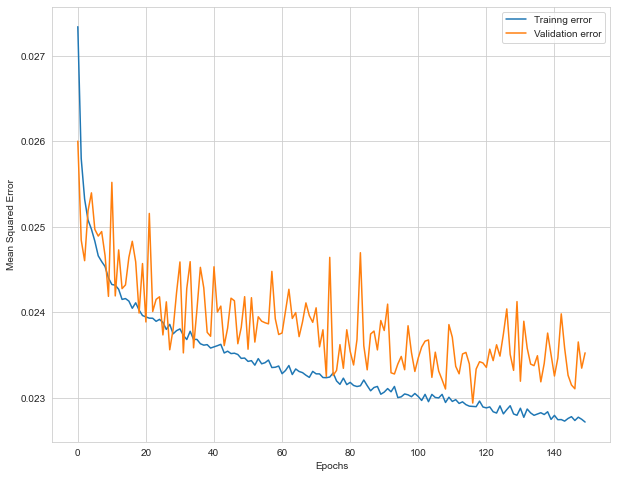

In [136]:
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = 'Trainng error')
plt.plot(history.history['val_loss'], label = 'Validation error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

In [188]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [256]:
# Preprocessing the training data
words = set()
for i in data_train:
    ingredients = ''
    for j in i['ingredients']:
        ingredients+= ' '+j.lower()
    words.add(ingredients)
words = list(words)

(array([1.1139e+04, 2.0710e+04, 7.0760e+03, 6.9900e+02, 3.7000e+01,
        7.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  14.5,  28. ,  41.5,  55. ,  68.5,  82. ,  95.5, 109. ,
        122.5, 136. ]),
 <BarContainer object of 10 artists>)

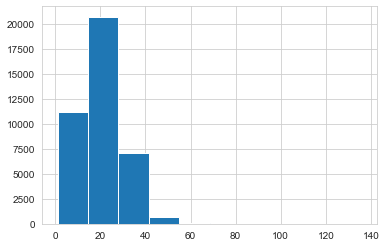

In [268]:
word_lengths = np.array([len(i.split()) for i in words])
plt.hist(word_lengths)

In [269]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(words)
vocab_size = len(tokenizer.word_index)+1
encoded_docs = tokenizer.texts_to_sequences(words)
padded_sequence = pad_sequences(encoded_docs, maxlen=40)

In [270]:
embedding_vector_length = 120
Model_2 = Sequential(
[
    Embedding(input_dim = vocab_size, output_dim = embedding_vector_length, input_length = 40),
    Flatten(),
    Dense(20),
    Softmax(1),
]
)
Model_2.compile(loss=mean_squared_error, optimizer= 'Adam', metrics= 'accuracy')
Model_2.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 120)           367800    
_________________________________________________________________
flatten_6 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                96020     
_________________________________________________________________
softmax_40 (Softmax)         (None, 20)                0         
Total params: 463,820
Trainable params: 463,820
Non-trainable params: 0
_________________________________________________________________


In [271]:
padded_sequence_df = pd.DataFrame(padded_sequence)
padded_sequence_norm = (padded_sequence_df - padded_sequence_df.mean())/padded_sequence_df.std()
history = Model_2.fit(padded_sequence ,y_dummies, validation_split= .15, epochs=15, batch_size = 4)

Epoch 1/15
8431/8431 [==============================] - 90s 11ms/step - loss: 0.0455 - accuracy: 0.1818 - val_loss: 0.0456 - val_accuracy: 0.1773
Epoch 2/15
8431/8431 [==============================] - 52s 6ms/step - loss: 0.0444 - accuracy: 0.2221 - val_loss: 0.0470 - val_accuracy: 0.1517
Epoch 3/15
8431/8431 [==============================] - 54s 6ms/step - loss: 0.0418 - accuracy: 0.2911 - val_loss: 0.0494 - val_accuracy: 0.1317
Epoch 4/15
8431/8431 [==============================] - 61s 7ms/step - loss: 0.0391 - accuracy: 0.3552 - val_loss: 0.0514 - val_accuracy: 0.1213
Epoch 5/15
8431/8431 [==============================] - 58s 7ms/step - loss: 0.0368 - accuracy: 0.4063 - val_loss: 0.0536 - val_accuracy: 0.1203
Epoch 6/15
8431/8431 [==============================] - 58s 7ms/step - loss: 0.0349 - accuracy: 0.4478 - val_loss: 0.0557 - val_accuracy: 0.1154
Epoch 7/15
8431/8431 [==============================] - 58s 7ms/step - loss: 0.0333 - accuracy: 0.4803 - val_loss: 0.0574 - val_a